<a href="https://colab.research.google.com/github/VallentinDS/Data-Science-Projects/blob/main/Cambridge_Crime_Data_2009_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the libraries

import pandas as pd
import numpy as np
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
%matplotlib inline

# Installing the kneed package.
# Uncomment and Re-run it when running the notebook again if using scikit-learn
# At the moment, I went for a manual application of the algorithm 

# !pip install kneed
# !pip install scikit-learn ipython

# visualisation setup
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
""""
Comment one or the other depending on which account you are using.
If you are Nikolaos, comment the personal google drive account code line and uncomment the other
"""

# code line for personal google drive account
# dataset = pd.read_csv("/content/drive/MyDrive/Programming/Kaggle Projects/K-Means Clustering/Cambridge Crime Data 2009-2016/Cambridge Crime Data 2009-2016.csv")

# code line for work google drive account
dataset = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/K-means_Clustering_Project/Cambridge Crime Data 2009-2016.csv")

In [ ]:
dataset.head(10)

,File Number,Date of Report,Crime Date Time,Crime,Reporting Area,Neighborhood,Location
0,2009-00002,01/01/2009 12:39:00 AM,1/1/09 0:39,Simple Assault,504.0,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA"
1,2009-00003,01/01/2009 01:34:00 AM,1/1/09 1:34,Simple Assault,610.0,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA"
2,2009-00004,01/01/2009 01:43:00 AM,01/01/2009 02:20 - 02:35,Aggravated Assault,708.0,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg..."
3,2009-00005,01/01/2009 02:27:00 AM,01/01/2009 02:20 - 02:45,Simple Assault,105.0,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA"
4,2009-00006,01/01/2009 02:34:00 AM,01/01/2009 02:15 - 02:35,Disorderly,708.0,Riverside,"1200 Massachusetts Avenue, Cambridge, MA"
5,2009-00007,01/01/2009 02:45:00 AM,1/1/09 2:45,Missing Person,507.0,Cambridgeport,"0 WOODROW WILSON COURT, Cambridge, MA"
6,2009-00008,01/01/2009 02:37:00 AM,1/1/09 2:37,Mal. Dest. Property,1108.0,North Cambridge,"100 MONTGOMERY STREET, Cambridge, MA"
7,2009-00009,01/01/2009 10:42:00 AM,01/01/2009 10:30 - 10:42,Simple Assault,411.0,Area 4,"600 Massachusetts Avenue, Cambridge, MA"
8,2009-00010,01/01/2009 10:47:00 AM,01/01/2009 10:35 - 10:47,Shoplifting,1201.0,Highlands,"200 ALEWIFE BROOK PKY, Cambridge, MA"
9,2009-00011,01/01/2009 12:37:00 PM,12/31/2008 10:00 - 01/01/2009 10:00,Hit and Run,510.0,Cambridgeport,"FAIRMONT Avenue & Fairmont STREET, Cambridge, MA"


In [ ]:
column_names = dataset.columns.to_list()
print(column_names)

['File Number', 'Date of Report', 'Crime Date Time', 'Crime', 'Reporting Area', 'Neighborhood', 'Location']


The data has 7 columns:

- File number - a reference number for the crime
- Date of report - when the report was made
- Crime - the type of crime
- Crime Date Time - The date and time of the crime
- Reporting Area - Subset of Neighborhood
- Neighbourhood - Neighborhood within Cambridge
- Location - specific location where crime took place


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56014 entries, 0 to 56013
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   File Number      56014 non-null  object 
 1   Date of Report   56014 non-null  object 
 2   Crime Date Time  56014 non-null  object 
 3   Crime            56014 non-null  object 
 4   Reporting Area   56012 non-null  float64
 5   Neighborhood     56012 non-null  object 
 6   Location         55931 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.0+ MB


In [ ]:
# total number of rows
len(dataset.index)

56014

In total, there are 56014 rows. Wew are missing minimum data for `Reporting Area` and `Neighborhood`. More data is missing in `Location` but that is not necessarily an issue there.

Let's find out:
- How many categories of crime are there?
- How many reporting areas are  there
- How many neighborhoods exist in the dataset?

In [ ]:
# finding the categories of crime

crime_types = dataset['Crime'].unique()
len(crime_types)

54

In [ ]:
# number of reporting areas
len(dataset['Reporting Area'].unique())

118

In [ ]:
# number of neighborhoods
len(dataset['Neighborhood'].unique())

14

In [ ]:
dataset['Neighborhood'].unique()

array(['Cambridgeport', 'Mid-Cambridge', 'Riverside', 'East Cambridge',
       'North Cambridge', 'Area 4', 'Highlands', 'Agassiz',
       'West Cambridge', 'Inman/Harrington', 'Peabody', 'MIT',
       'Strawberry Hill', nan], dtype=object)

In [ ]:
dataset['Location'].unique()

array(['400 Massachusetts Avenue, Cambridge, MA',
       '200 HAMPSHIRE STREET, Cambridge, MA',
       'DUNSTER STREET & MOUNT AUBURN STREET, Cambridge, MA', ...,
       '100 PARKER ST, Cambridge, MA', '0 Soden St, Cambridge, MA',
       'University Rd & Mount Auburn St, Cambridge, MA'], dtype=object)

So there are 54 different types of crime, 118 different reporting areas, and 13 different neighborhoods (note, not 14 as one is an `nan` entry).

## Data Cleaning

Let's start with some data cleaning. Writing these down just so I can remember what to clean and make a plan because I suck at (data) planning.
- renaming the columns to a more pythonian way
- Split the `date of the report` by crime date, crime start time, crime end date and crime end time
- Split the Location for street

In [ ]:
dataset.rename(columns={
    'File Number': 'file_number',
    'Date of Report': 'date_report',
    'Crime Date Time': 'crime_date',
    'Crime':'crime',
    'Reporting Area': 'reporting_area',
    'Neighborhood': 'neighborhood',
    'Location': 'location'
}, inplace= True)

In [ ]:
# creating a new dataframe 

clean_data = dataset.copy()

In [ ]:
clean_data['report_date'] = clean_data['date_report'].str.split(' ').str.get(0)
clean_data['report_date']

0        01/01/2009
1        01/01/2009
2        01/01/2009
3        01/01/2009
4        01/01/2009
            ...    
56009    09/30/2016
56010    09/30/2016
56011    09/30/2016
56012    09/30/2016
56013    09/30/2016
Name: report_date, Length: 56014, dtype: object

In [ ]:
clean_data['time_report'] = clean_data['date_report'].str.split(' ').str.get(1).astype('datetime64[ns]')
clean_data['time_report'] = pd.to_datetime(clean_data['time_report'], format= '%H:%M').dt.time

In [ ]:
clean_data['crime_st_time'] = clean_data['crime_date'].str.split(' ').str.get(0)
clean_data['crime_st_time'].head(15)

clean_data['crime_end_time'] = clean_data['crime_date'].str.split(' ').str.get(-1)
clean_data['crime_end_time'].head(15)



0      0:39
1      1:34
2     02:35
3     02:45
4     02:35
5      2:45
6      2:37
7     10:42
8     10:47
9     10:00
10    14:05
11    13:45
12    02:00
13    15:30
14     2:00
Name: crime_end_time, dtype: object

In [ ]:
clean_data['crime_end_date'] = clean_data['crime_date'].str.extract(r'\s(\d*/\d*/\d*)')
clean_data['crime_end_date'].head(15)


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9     01/01/2009
10           NaN
11           NaN
12    01/01/2009
13           NaN
14           NaN
Name: crime_end_date, dtype: object

In [ ]:
clean_data.head()

,file_number,date_report,crime_date,crime,reporting_area,neighborhood,location,report_date,time_report,crime_st_time,crime_end_time,crime_end_date
0,2009-00002,01/01/2009 12:39:00 AM,1/1/09 0:39,Simple Assault,504.0,Cambridgeport,"400 Massachusetts Avenue, Cambridge, MA",01/01/2009,12:39:00,1/1/09,0:39,NaN
1,2009-00003,01/01/2009 01:34:00 AM,1/1/09 1:34,Simple Assault,610.0,Mid-Cambridge,"200 HAMPSHIRE STREET, Cambridge, MA",01/01/2009,01:34:00,1/1/09,1:34,NaN
2,2009-00004,01/01/2009 01:43:00 AM,01/01/2009 02:20 - 02:35,Aggravated Assault,708.0,Riverside,"DUNSTER STREET & MOUNT AUBURN STREET, Cambridg...",01/01/2009,01:43:00,01/01/2009,02:35,NaN
3,2009-00005,01/01/2009 02:27:00 AM,01/01/2009 02:20 - 02:45,Simple Assault,105.0,East Cambridge,"100 SCIARAPPA STREET, Cambridge, MA",01/01/2009,02:27:00,01/01/2009,02:45,NaN
4,2009-00006,01/01/2009 02:34:00 AM,01/01/2009 02:15 - 02:35,Disorderly,708.0,Riverside,"1200 Massachusetts Avenue, Cambridge, MA",01/01/2009,02:34:00,01/01/2009,02:35,NaN


In [ ]:
clean_data.isna().sum()

file_number           0
date_report           0
crime_date            0
crime                 0
reporting_area        2
neighborhood          2
location             83
report_date           0
time_report           0
crime_st_time         0
crime_end_time        0
crime_end_date    42959
dtype: int64

In [ ]:
clean_data['crime'].value_counts()

Larceny from MV           4837
Hit and Run               4662
Domestic Dispute          3909
Mal. Dest. Property       3671
Simple Assault            3295
Larceny from Building     2857
Shoplifting               2789
Larceny of Bicycle        2750
Housebreak                2676
Forgery                   2584
Warrant Arrest            2575
Larceny from Person       2276
Larceny from Residence    1743
Aggravated Assault        1726
Threats                   1637
Auto Theft                1102
Missing Person             950
Flim Flam                  939
Harassment                 816
Street Robbery             759
Drugs                      673
Admin Error                660
Accident                   627
Commercial Break           584
Phone Calls                450
OUI                        387
Suspicious Package         381
Violation of R.O.          377
Trespassing                359
Disorderly                 306
Larceny (Misc)             269
Taxi Violation             259
Larceny 

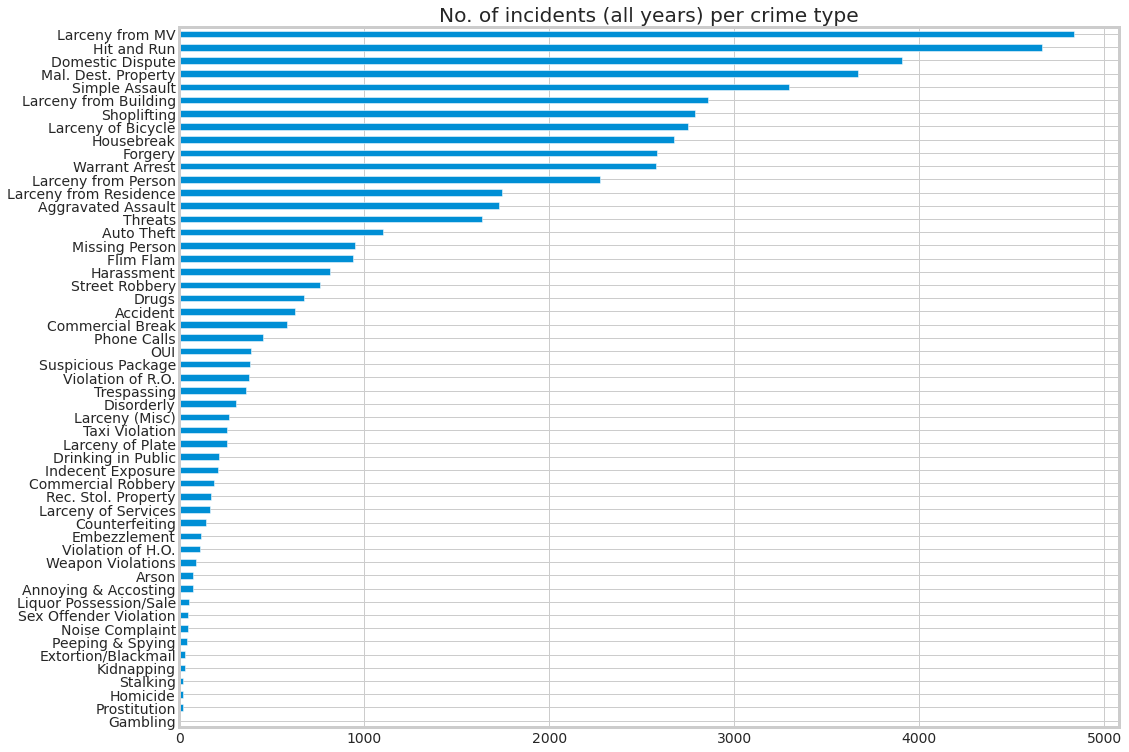

In [ ]:
# removing the data that was cause by Admin Error
clean_data.drop(clean_data.loc[clean_data['crime'] == 'Admin Error'].index, inplace=True)

# plotting a bar chart to see the number of incidents for each crime
clean_data['crime'].value_counts().sort_values(ascending=True).plot(kind='barh', 
                                                                    figsize=(15,12),
                                                                    title='No. of incidents (all years) per crime type')

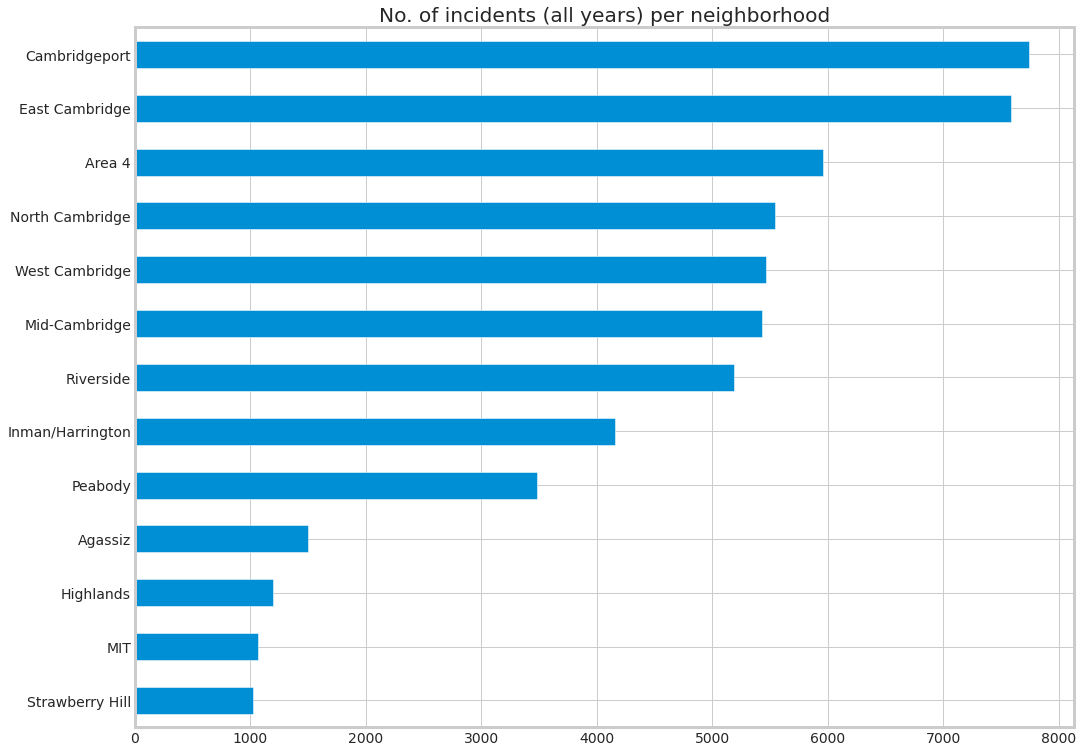

In [ ]:
# plotting a bar chart to see the number of incidents per neighborhood
clean_data['neighborhood'].value_counts().sort_values(ascending=True).plot(kind='barh', 
                                                                    figsize=(15,12),
                                                                    title='No. of incidents (all years) per neighborhood')

In [ ]:
clean_data.groupby('neighborhood')['crime'].count().sort_values(ascending=False)

neighborhood
Cambridgeport       7748
East Cambridge      7586
Area 4              5961
North Cambridge     5546
West Cambridge      5463
Mid-Cambridge       5429
Riverside           5191
Inman/Harrington    4157
Peabody             3481
Agassiz             1501
Highlands           1199
MIT                 1069
Strawberry Hill     1022
Name: crime, dtype: int64

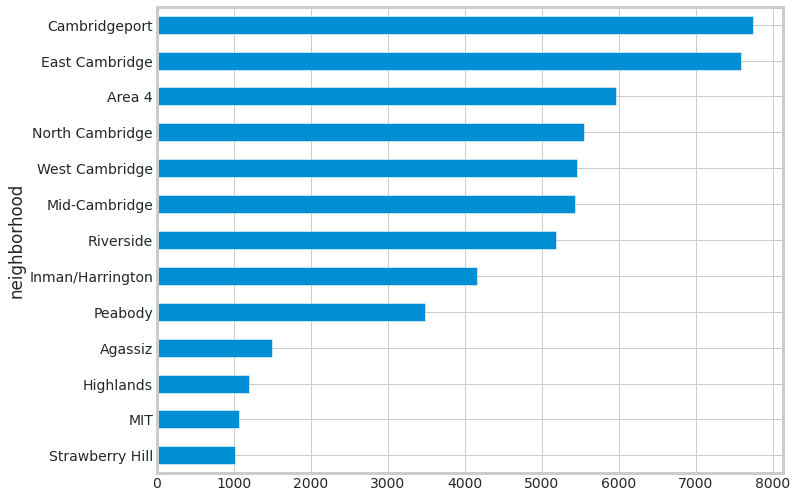

In [ ]:
clean_data.groupby('neighborhood')['crime'].count().sort_values(ascending=True).plot(kind='barh',
                                                                                     figsize= (10,8))

In order to use K-Means clustering, we will have to use numerical data. 

For this, we will vectorize the text data using TF-IDF 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# instantiate the vectorizer object

tfidf_vectorizer = TfidfVectorizer(
    analyzer= 'word',
    stop_words='english',
    token_pattern = r".*") # using ngram_range to extend the range from multiple words

count_vectorizer = CountVectorizer(
    analyzer= 'word',
    token_pattern = r".*")


from time import time
t0 = time()
# converting them into a matrix
tfidf_crime = tfidf_vectorizer.fit_transform(clean_data.crime)
count_crime = count_vectorizer.fit_transform(clean_data.crime)


print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {tfidf_crime.shape[0]}, n_features: {tfidf_crime.shape[1]}")
print('\n')
print(f"n_samples: {count_crime.shape[0]}, n_features: {count_crime.shape[1]}")

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [''] not in stop_words.
  % sorted(inconsistent)


vectorization done in 0.490 s
n_samples: 55354, n_features: 54


n_samples: 55354, n_features: 54


In [ ]:
tfidf_array = tfidf_crime.toarray()
tfidf_array = tfidf_array[:,1:]

count_array = count_crime.toarray()[:,1:] #indexing from the 2nd column because the first column is picking an empty column
count_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
tfidf_token = tfidf_vectorizer.get_feature_names_out()[1:] # the indexing is done becuse there the first value is empty

count_token = count_vectorizer.get_feature_names_out()[1:] # the indexing is done becuse there the first value is empty

# it results in a list that contains all the crime names

In [ ]:
df_count_vect = pd.DataFrame(data = count_array, 
                             index= clean_data.crime,
                             columns = count_token)

df_tfidf_vect = pd.DataFrame(data= tfidf_array,
                             index= clean_data.crime,
                             columns = tfidf_token)

In [ ]:
df_count_vect.head()

,accident,aggravated assault,annoying & accosting,arson,auto theft,commercial break,commercial robbery,counterfeiting,disorderly,domestic dispute,...,stalking,street robbery,suspicious package,taxi violation,threats,trespassing,violation of h.o.,violation of r.o.,warrant arrest,weapon violations
crime,,,,,,,,,,,,,,,,,,,,,
Simple Assault,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Simple Assault,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aggravated Assault,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Simple Assault,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Disorderly,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tfidf_vect

,accident,aggravated assault,annoying & accosting,arson,auto theft,commercial break,commercial robbery,counterfeiting,disorderly,domestic dispute,...,stalking,street robbery,suspicious package,taxi violation,threats,trespassing,violation of h.o.,violation of r.o.,warrant arrest,weapon violations
crime,,,,,,,,,,,,,,,,,,,,,
Simple Assault,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Simple Assault,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aggravated Assault,0.0,0.975851,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Simple Assault,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Disorderly,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.98722,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Larceny from Residence,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hit and Run,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Harassment,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tfidf_vect = df_tfidf_vect.reset_index(level=0)


In [ ]:
df_tfidf_vect= df_tfidf_vect.iloc[:,2:]

df_tfidf_vect

In [ ]:
df_tfidf_vect = df_tfidf_vect.drop_duplicates()
df_tfidf_vect

# replace in the original dataframe with the vector of the crime

What I do not know to do:
1. I don't know how to use this with a manual application of the K-means function
  - 10.10.2022 still pending -_-

2. How do we proceed when we have crime types that have 1 word and others have more than 2? 
  - solved this by adding the `pattern` parameter in the TfidfVectorizer and CountVectorizer functions

In [ ]:
df_count_vect = df_count_vect.drop_duplicates()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init= 'k-means++',
    n_clusters = 10,
    n_init = 10,
    max_iter= 1000,
    random_state= 3
)

# Compute cluster centers and predict cluster index for each sample
kmeans_predict= kmeans.fit_predict(df_count_vect)
kmeans_predict

array([8, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0,
       9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 5, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Cluster 0 is highly present over the KMeans algorithm

In [ ]:
# kmeans.cluster_centers_

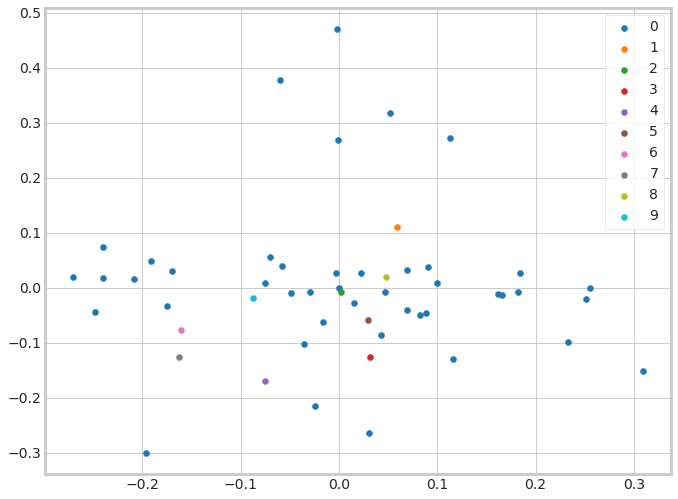

In [ ]:
from sklearn.decomposition import PCA

# intializing the PCA with the number of components to keep
pca = PCA(n_components = 10)

# fit PCA with the dataframe and apply the dimensionality reduction
pca_result_count = pca.fit_transform(df_count_vect)

# plt.scatter(x= pca_result_count[:,0],
#             y= pca_result_count[:,1],
#             c)
# plt.show()

category10_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(figsize=(10, 8))

for i,z in zip(range(10), category10_colors):
  plt.scatter(x= pca_result_count[kmeans_predict== i,0],
              y= pca_result_count[kmeans_predict== i,1],
              label= i,
              color= z
  )
plt.legend()
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077,
       0.01923077, 0.01923077, 0.01923077, 0.01923077, 0.01923077])

In [ ]:
kmeans_predict_tfidf= kmeans.fit_predict(df_tfidf_vect)
kmeans_predict_tfidf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 9, 1, 1, 3, 1, 1, 1, 8, 6,
       1, 1, 7, 2, 1, 1, 5, 1, 1], dtype=int32)

Here is cluster 1 that is taking over most of the clusters

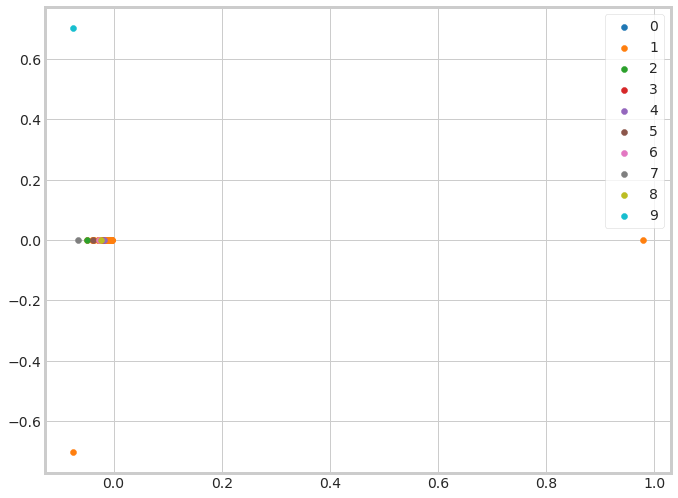

In [ ]:
pca = PCA(n_components = 2)
pca_result_tfidf = pca.fit_transform(df_tfidf_vect)

# plt.scatter(x= pca_result[:,0],
#             y= pca_result[:,1],
#             c)
# plt.show()

category10_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

fig, ax = plt.subplots(figsize=(10,8))
for i,z in zip(range(10), category10_colors):
  plt.scatter(x= pca_result_tfidf[kmeans_predict_tfidf== i,0],
              y= pca_result_tfidf[kmeans_predict_tfidf== i,1],
              label= i,
              color= z
  )
plt.legend()
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.01971424, 0.01965275])

In [ ]:
df_tfidf_vect

,accident,aggravated assault,annoying & accosting,arson,auto theft,commercial break,commercial robbery,counterfeiting,disorderly,domestic dispute,...,stalking,street robbery,suspicious package,taxi violation,threats,trespassing,violation of h.o.,violation of r.o.,warrant arrest,weapon violations
crime,,,,,,,,,,,,,,,,,,,,,
Simple Assault,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Aggravated Assault,0.000000,0.975851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Disorderly,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.98722,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Missing Person,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Mal. Dest. Property,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Shoplifting,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Hit and Run,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
Trespassing,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.98655,0.000000,0.000000,0.000000,0.000000
Larceny from MV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# placing the PCA results in a dataframe
tfidf_pca_dataframe = pd.DataFrame(data= pca_result_tfidf,
                                   columns =['PC1', 'PC2']
                                   )

#turning the index 'crime' into a column and concatinating it with the PCA results
df_tfidf_vect = df_tfidf_vect.reset_index(level=0)

final_df = pd.concat([df_tfidf_vect['crime'], tfidf_pca_dataframe], axis= 1)
final_df


,crime,PC1,PC2
0,Simple Assault,-0.004219,-2.846771e-15
1,Aggravated Assault,-0.006012,-2.002721e-15
2,Disorderly,-0.014278,-1.580705e-15
3,Missing Person,-0.008170,-6.242828e-15
4,Mal. Dest. Property,-0.003964,-2.326612e-15
5,Shoplifting,-0.004635,-5.979182e-15
6,Hit and Run,-0.003441,-3.542570e-15
7,Trespassing,-0.013202,-7.172184e-15
8,Larceny from MV,-0.003365,-3.222635e-15
9,Larceny (Misc),-0.015211,-2.097264e-14


In [ ]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(1,1,1)
# ax.set_xlabel('Principal Component 1', fontsize= 12)
# ax.set_ylabel('Principal Component 2', fontsize= 12)
# ax.set_title ('PCA with k=2', fontsize= 16)

# crimes = df_tfidf_vect['crime'].to_list()
# colors = 'tab20'

# for crime in crimes:
#   indices_to_keep = final_df['crime'] == crime
#   col_map = plt.get_cmap('tab20')
#   ax.scatter(final_df.loc[indices_to_keep, 'PC1'], final_df.loc[indices_to_keep, 'PC2'], cmap= 'tab20', s= 25)

# ax.legend(crimes, label='Inline label')
# ax.grid()

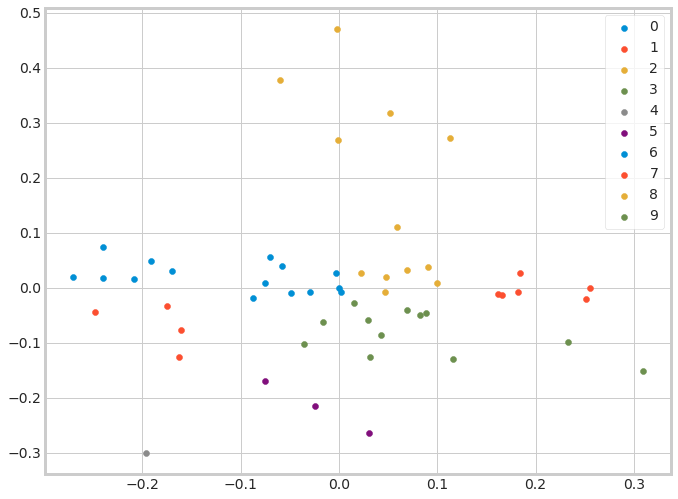

In [ ]:
pca_count = kmeans.fit_predict(pca_result_count)


category10_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
fig, ax = plt.subplots(figsize=(10,8))

for i,z in zip(range(10), category10_colors):
  plt.scatter(x= pca_result_count[pca_count== i,0],
              y= pca_result_count[pca_count== i,1],
              label= i)
plt.legend()
plt.show()

In [ ]:
"""
Steps I did for the training and fitting:
- Find the count to the vectorization
- Transform over the PCA
- Predict over the KMeans
  - these are the steps to be done to assign a new crime to a cluster


AFter vectorization, we compressed to a lower dimensional space with a PCA (it made too sparse).
The PCA compresses the data by keeping all info that we already have => it is easier to KMeans to separate the clusters

Replace Crime column with the PCA results. Same thing can be done to other columns
"""


"""
Possible Steps to do:
- perform TF-IDF on the other columns: Reporting Area, Neighbourhood, Location
- do the PCA on those columns


Question:
1. Each of the PCA that has n=2 components have a very low variance, around 2%. This means that we need to increase the number of components in order to not lose a lot of data.
2. What would be the next steps now?

SyntaxError: ignored